기본값 : 0  
INFO 로그 필터링 : 1  
WARNING 로그 필터링 : 2  
ERROR 로그 필터링 : 3  

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [3]:
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from datetime import datetime
import time
from tqdm import tqdm

from model_layer import *

# 데이터 셋 만들기

In [4]:
M6_Universe = pd.read_csv('M6_Universe.csv')

start_date = "2021-05-15" #OGN에셋 길이에 맞춤
end_date = "2022-09-16"

os.makedirs("./stock/asset",exist_ok=True)

for asset in tqdm(M6_Universe.symbol):
    stock = yf.download(asset, start=start_date, end = end_date, progress = False)
    stock.to_csv("./stock/asset/"+asset+".csv")


100%|█████████████████████████████████████████| 100/100 [00:34<00:00,  2.87it/s]


In [5]:
os.makedirs("./stock/index",exist_ok=True)

#S&P500 / 나스닥 / 다우존스 / 미국채 10년물 금리 / 변동성 지수(S&P 500 지수 옵션에 기반한 변동성) / 골드만삭스 원자재 지수(선물옵션 기반) / 원유
Index_list = ["SP500", "NASDAQ", "DOWJONES", "TNX", "VIX", "GSCI" , "Oil"]
Index_code = ['ES=F', 'YM=F', 'NQ=F', '^TNX', '^VIX', 'GD=F', 'CL=F']

Index_pd = pd.DataFrame([Index_list, Index_code],index=['name','symbol']).transpose()

for i in tqdm(range(Index_pd.shape[0])):
    stock = yf.download(Index_pd.symbol[i], start=start_date, end = end_date, progress = False)
    stock.to_csv("./stock/index/"+Index_pd.name[i]+".csv")

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.31it/s]


## 데이터셋 클래스

In [6]:
class dataset_for_transformer:
    '''
    [22-08-19(화)]
    데이터셋 만들기(Ver.2)
    
    MI-LSTM처럼 상관 계수 구할 예정!
    에셋별 scaler를 수동 적용.
    Date_Range 생성.
    원본 유지.
    
    메모:
        * cal_corr / load_file / get_dataset 만들 예정
        * 인덱스도 corr을 계산하는게 좋을까, 아니면 따로 넣는게 좋을까?
        * 가격 그대로를 corr계산할까, 수익률[(현재-과거)/과거]로 계산할까?
        * corr계산의 길이는? window사이즈의 2~2.5배? 아니면 고정길이?
    
    Parameter:
        asset_list        : 사용 에셋 리스트. csv파일이 존재하는 에셋 이름으로 가지고 있어야함.
        index_list        : 사용 인덱스 리스트. csv파일이 존재하는 인덱스 이름으로 가지고 있어야함.
        pos_corr          : 양의 상관 계수의 주식 수.
        neg_corr          : 음의 상관 계수의 주식 수.
        path("./stock")   : 에셋, 인덱스 파일 경로. asset은 path+/asset에, index는 path+/index에 있어야 함.
        train_ratio(None) : trainset의 비율. None이면 test셋 만들지 않음.

    '''
    def __init__(self, asset_list, index_list, pos_corr, neg_corr, path = "./stock"):
        self.asset_list = asset_list
        self.index_list = index_list
        self.pos_corr = pos_corr
        self.neg_corr = neg_corr
        self.__file_path = path
        
        self.dataset_asset = self.load_file(self.asset_list,"/asset")
        self.dataset_index = self.load_file(self.index_list,"/index")
        
        self.dataset_asset_scaled = self.dataset_asset.copy()
        self.dataset_index_scaled = self.dataset_index.copy()
    
    def calculate_correlation(self,dataset,window_size):
        #get_dataset안에서 사용될 예정
        #에셋 이름을 받을 것이고, 길이는 이 함수 전에 미리 자를 것(window_size의 1.5배 정도)
        #dataset은 (corr계산길이 * 100)인 pd.DataFrame
        corr_dataset = dataset.corr(method='pearson').copy()
        cut_dataset = dataset.iloc[-window_size:,:].copy()
        
        hist_idxs = [i for i in range(0,self.pos_corr+1)]#target+양의 corr 개수
        hist_idxs.extend([i for i in range(-self.neg_corr,0,1)])#음의 corr 개수
        
        target_np = []
        pos_np = []
        neg_np = []
        for i in range(100):
            select_asset = corr_dataset.iloc[:,i].sort_values(ascending=False).index[hist_idxs].to_list()
            
            target_np.append(cut_dataset[select_asset[0]].to_numpy()[np.newaxis,:])
            pos_np.append(cut_dataset[select_asset[1:self.pos_corr+1]].to_numpy().T[np.newaxis,:])
            neg_np.append(cut_dataset[select_asset[-self.neg_corr:]].to_numpy().T[np.newaxis,:])
        
        target_np = np.concatenate(target_np,axis=0) #(100, window_size)
        pos_np = np.concatenate(pos_np,axis=0) #(100, self.pos_corr, window_size)
        neg_np = np.concatenate(neg_np,axis=0) #(100, self.neg_corr, window_size)
        return {'target':target_np,
                'pos':pos_np,
                'neg':neg_np}
    
    def get_dataset(self, window_size, forecast_range = 20, corr_length_ratio = 1.5):
        W = window_size
        corr_length = round(W * corr_length_ratio)
        dataset_length = self.dataset_asset.shape[0]
        
        targets = []
        positives = []
        negatives = []
        indexes = []
        Ys = []
        for start_idx in tqdm(range(dataset_length-corr_length-forecast_range),desc='create dataset... '):
            calc_data = self.calculate_correlation(self.dataset_asset_scaled.iloc[start_idx:start_idx+corr_length,:], W)
            index_ = self.dataset_index_scaled.iloc[start_idx+corr_length-W:start_idx+corr_length,:].copy().to_numpy().T#(인덱스 개수, window_size)
            index_data=[index_[np.newaxis,:,:].copy() for _ in range(100)]
            index_data=np.concatenate(index_data,axis=0)#(100,인덱스 개수, window_size)
            #총 길이 forecast_range+1이 되도록(일단은)
            Y = self.dataset_asset_scaled.iloc[start_idx+corr_length-1:start_idx+corr_length+forecast_range,:].copy().to_numpy().T#(100,forecast_range+1)
            
            targets.append(calc_data['target'].copy())
            positives.append(calc_data['pos'].copy())
            negatives.append(calc_data['neg'].copy())
            indexes.append(index_data.copy())
            Ys.append(Y.copy())
            
        targets=np.concatenate(targets,axis=0)
        positives=np.concatenate(positives,axis=0)
        negatives=np.concatenate(negatives,axis=0)
        indexes=np.concatenate(indexes,axis=0)
        Ys=np.concatenate(Ys,axis=0)
        
        return {'target':targets,
                'positive':positives,
                'negative':negatives,
                'index':indexes,
                'Y':Ys}

    
    def load_file(self, file_list, sub_path):
        ASSET = file_list

        dataset_pd = None
        for asset in ASSET:
            data_one_asset = pd.read_csv(f"{self.__file_path}{sub_path}/{asset}.csv")[['Date','Adj Close']]
            data_one_asset.columns = ['Date',asset]
            if dataset_pd is None:
                dataset_pd = data_one_asset.copy()
            else:
                dataset_pd = pd.merge(left = dataset_pd, right = data_one_asset, how = 'outer', on = 'Date')
        dataset_pd['Date'] = pd.to_datetime(dataset_pd['Date'])
        dataset_pd.sort_values(by=['Date'],inplace=True)
        dataset_pd.reset_index(drop=True,inplace = True)
        dataset_pd.fillna(method='ffill',inplace=True)
        dataset_pd.fillna(method='bfill',inplace=True)
        return dataset_pd
    
    def apply_scale(self):
        dataset, indexset = self.dataset_asset.copy(), self.dataset_index.copy()
        
        merge_total = pd.merge(left=dataset, right=indexset, how='left', on='Date')
        merge_total.sort_values(by=['Date'], inplace=True)
        merge_total.fillna(method='ffill', inplace=True)
        merge_total.fillna(method='bfill', inplace=True)
        
        dataset_scaler = MinMaxScaler(feature_range=(-1, +1))
        indexset_scaler = MinMaxScaler(feature_range=(-1, +1))
        
        dataset_scaler.fit(merge_total[dataset.columns[1:]])
        indexset_scaler.fit(merge_total[indexset.columns[1:]])
        
        merge_total[dataset.columns[1:]] = dataset_scaler.transform(merge_total[dataset.columns[1:]])
        merge_total[indexset.columns[1:]] = indexset_scaler.transform(merge_total[indexset.columns[1:]])
        
        scaled_dataset = merge_total[dataset.columns[1:]].copy()
        scaled_indexset = merge_total[indexset.columns[1:]].copy()
        
        self.dataset_asset_scaled = scaled_dataset
        self.dataset_index_scaled = scaled_indexset
        self.asset_scaler = dataset_scaler
        self.index_scaler = indexset_scaler
        self.Date_range = merge_total['Date']
        

In [7]:
model_dataset = dataset_for_transformer(asset_list=M6_Universe.symbol, 
                                        index_list=Index_list, 
                                        pos_corr=10, 
                                        neg_corr=10)
model_dataset.apply_scale()

In [8]:
final_dataset = model_dataset.get_dataset(window_size=25, 
                                forecast_range = 20, 
                                corr_length_ratio = 1.5)
print(final_dataset['target'].shape,final_dataset['positive'].shape,final_dataset['negative'].shape,final_dataset['index'].shape,final_dataset['Y'].shape)

create dataset... : 100%|█████████████████████| 290/290 [00:23<00:00, 12.20it/s]

(29000, 25) (29000, 10, 25) (29000, 10, 25) (29000, 7, 25) (29000, 21)


## 데이터 셋 폼

In [9]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
# inputs,pos_inputs,neg_inputs,index_inputs, dec_inputs

split_point=round(final_dataset['Y'].shape[0]*0.8)
print(split_point)

BATCH_SIZE = 128
BUFFER_SIZE = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': final_dataset['target'][:split_point],
        'pos_inputs':final_dataset['positive'][:split_point],
        'neg_inputs':final_dataset['negative'][:split_point],
        'index_inputs':final_dataset['index'][:split_point],
        'dec_inputs': final_dataset['Y'][:split_point, :-1] # 디코더의 입력. 마지막 값이 제거된다.(t 시점 ~ t+19 시점)
    },
    {
        'outputs': final_dataset['Y'][:split_point, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 input의 마지막 값이 제거된다.(t+1 시점 ~ t+20 시점)
    },
))

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

23200


In [10]:
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': final_dataset['target'][split_point:],
        'pos_inputs':final_dataset['positive'][split_point:],
        'neg_inputs':final_dataset['negative'][split_point:],
        'index_inputs':final_dataset['index'][split_point:],
        'dec_inputs': final_dataset['Y'][split_point:, :-1] # 디코더의 입력. 마지막 값이 제거된다.(t 시점 ~ t+19 시점)
    },
    {
        'outputs': final_dataset['Y'][split_point:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 input의 마지막 값이 제거된다.(t+1 시점 ~ t+20 시점)
    },
))

test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 모델 생성

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


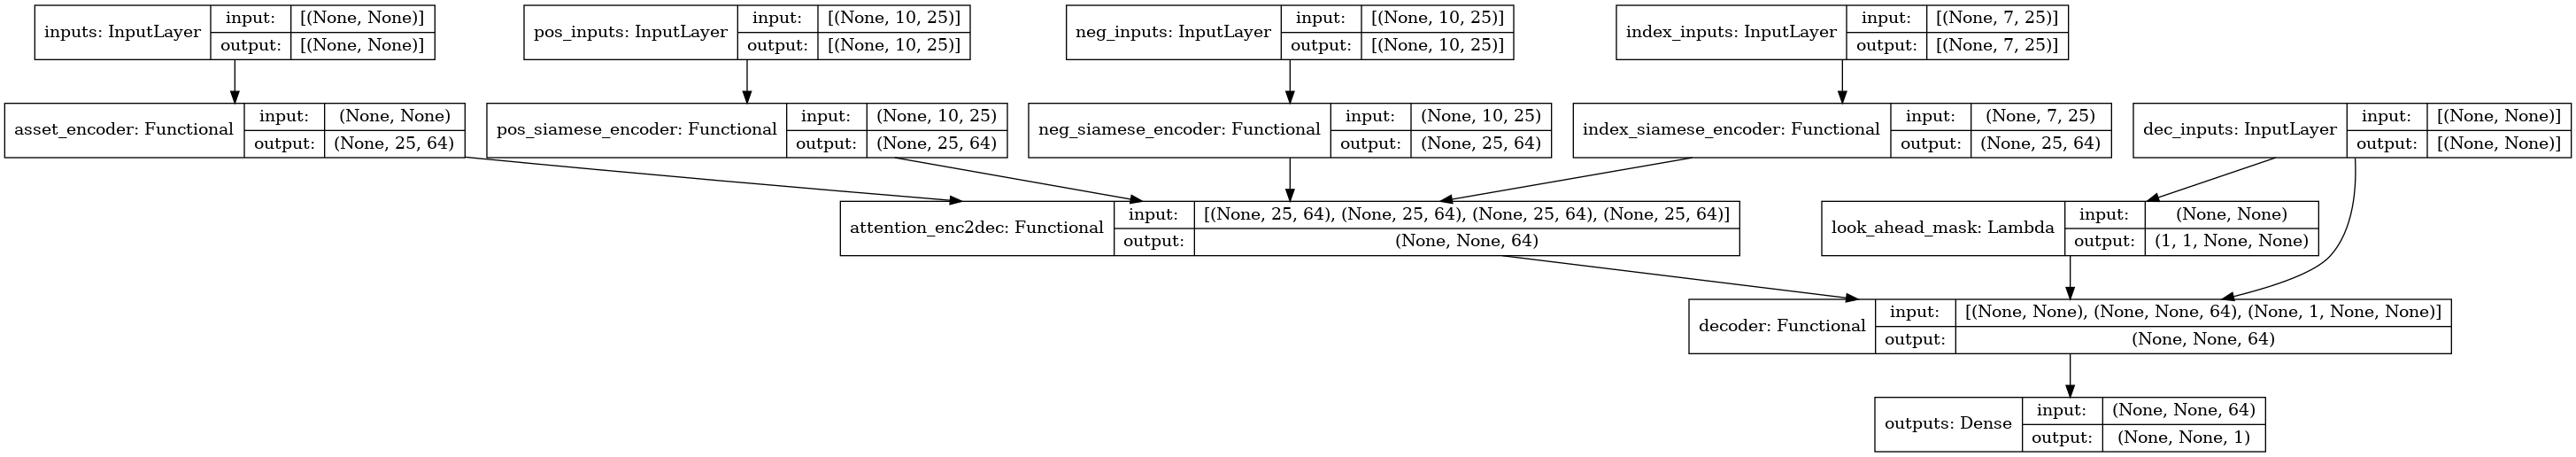

In [11]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
WINDOW_SIZE = 25
FORECAST_RANGE = 20
NUM_LAYERS = 4  #인코더, 디코더의 층 수
DFF = 128 #트랜스포머 내부의 피드-포워드 신경망의 은닉층 크기(입력층, 출력층은 d_model) 
D_MODEL = 64 #인코더, 디코더에서의 정해진 출력 크기 = 임베딩 벡터의 차원
NUM_HEADS = 8 #트랜스포머 내 어텐션에서 여러개로 분할 후 병렬로 어탠션 수행함. 이때의 병렬의 수
DROPOUT = 0.1

model = multi_enc_transformer(
    window_size = WINDOW_SIZE,
    forecast_range = FORECAST_RANGE,
    P=10,
    N=10,
    I=7,
    num_layers = NUM_LAYERS,
    dff = DFF,
    d_model = D_MODEL,
    num_heads = NUM_HEADS,
    dropout = DROPOUT,
    name="stock_transformer")

tf.keras.utils.plot_model(model, to_file='multi_encoder_transformer.png', show_shapes=True)

# 모델 학습!

In [12]:
#model.compile(optimizer = tf.keras.optimizers.Adam(),
#              loss = tf.keras.losses.MeanSquaredError(),
#              metrics=[tf.keras.metrics.RootMeanSquaredError(),
#                       tf.keras.metrics.MeanAbsolutePercentageError()]
#             )
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.MeanSquaredError()
             )

In [13]:
callback_path = './transformer/ver_0916'

os.makedirs(f'{callback_path}/ckpt', exist_ok=True)
ckpt_path = callback_path+'/ckpt/ckpt_{epoch:02d}-{val_loss:.4f}'
callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    monitor='val_loss',
    save_best_only = True,
    save_weights_only=True,
    verbose=1
)

os.makedirs(f'{callback_path}/tsbd', exist_ok=True)
callback_tsbd = tf.keras.callbacks.TensorBoard(f'{callback_path}/tsbd')

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.8 ** (epoch-5)
callback_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

2022-09-16 15:16:27.918974: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES


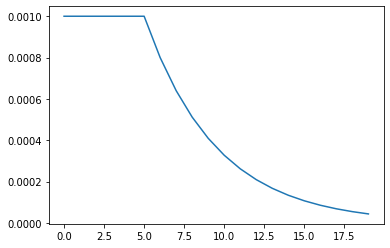

In [14]:
lr = 0.001
e = np.arange(20)

r = [scheduler(e_,lr) for e_ in e]
plt.plot(e,r)

한 에폭에 약 400s

In [15]:
model.fit(train_dataset, epochs=20, validation_data=test_dataset, verbose = 1, callbacks=[callback_ckpt,callback_scheduler,callback_tsbd])

Epoch 1/20
  1/182 [..............................] - ETA: 7:20 - loss: 3.0285

2022-09-16 15:20:00.836888: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES


182/182 [==============================] - 252s 1s/step - loss: 0.7569 - val_loss: 0.1150

Epoch 00001: val_loss improved from inf to 0.11500, saving model to ./transformer/ver_0916/ckpt/ckpt_01-0.1150
Epoch 2/20
182/182 [==============================] - 253s 1s/step - loss: 0.0820 - val_loss: 0.0318

Epoch 00002: val_loss improved from 0.11500 to 0.03182, saving model to ./transformer/ver_0916/ckpt/ckpt_02-0.0318
Epoch 3/20
182/182 [==============================] - 249s 1s/step - loss: 0.0251 - val_loss: 0.0114

Epoch 00003: val_loss improved from 0.03182 to 0.01138, saving model to ./transformer/ver_0916/ckpt/ckpt_03-0.0114
Epoch 4/20
182/182 [==============================] - 253s 1s/step - loss: 0.0156 - val_loss: 0.0090

Epoch 00004: val_loss improved from 0.01138 to 0.00896, saving model to ./transformer/ver_0916/ckpt/ckpt_04-0.0090
Epoch 5/20
182/182 [==============================] - 248s 1s/step - loss: 0.0134 - val_loss: 0.0099

Epoch 00005: val_loss did not improve from 0.

```bash
tensorboard --logdir=~/바탕화면/main_drive/LeeJaeYong/Forecast_stock/2.Transformer/transformer/ver_0916/tsbd
```
-------
혹시 이런 에러가 뜬다면...
> E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES

```bash
/usr/bin/google-chrome-stable --enable-blink-features=ShadowDOMV0,CustomElementsV0,HTMLImports
```